Dr. B has recommended to do the notebook here in colab so that we all have the same data and can easily run it. I think it's a good idea so I'm porting it over now. Still saving to the git repo though.

Later, once this is complete, will refresh on the newly refactored codebase to do BoW on this and then Carlos can test it with his shiny new clfs.

Right now this is finished, currently setting up a Caviness job to run through everything.

In [1]:
# imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import butter, sosfilt, welch, freqz, sosfreqz, filtfilt, lfilter
from scipy.fft import rfft, rfftfreq, irfft
from typing import List, Tuple

In [2]:
# just a handful for testing the notebook
emotion_subj_list = ['01', '02', '03', '04']
frolich_subj_list = ['01', '02', '03', '04']

Below code grabs PSD for us and plots it. Note that this will give us PSD by channel. We'll want to be careful about that for broadcasting purposes.

In [3]:
def psd(data, fs=256, nperseg=256):
    """
    Compute the Power Spectral Density (PSD) of the given data.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject
    - fs: sampling frequency (default: 256 Hz)
    - nperseg: length of each segment for Welch's method (default: 256)

    Returns:
    - f: array of sample frequencies (x-axis)
    - Pxx: power spectral density of the data (y-axis)
    """

    f, Pxx = welch(data, fs=fs, nperseg=nperseg)
    return f, Pxx

# Define a function to plot PSD
def plot_psd(data, fs=256, nperseg=256, psds=None, title='PSD'):
    """
    Plot the Power Spectral Density (PSD) of the given data.

    Note: right now this is straight averaging, not the barycenter norming I do later.
    If I want to do the norming, apply that first and then this will not average for me.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject
    - fs: sampling frequency (default: 256 Hz)
    - nperseg: length of each segment for Welch's method (default: 256)
    """
    plt.figure(figsize=(12, 8))

    for i, subj_data in enumerate(data):
        # If subj_data is multi-dimensional, average across the channels

        """
        Note, the below two are different because in the first I average the channels before taking the PSD,
        and in the second I average the channels after taking the PSD.

        Maybe should ask this to Dr. B and Carlos. Which is better since they do seem to result in some differences

        In the rest, when calculating the barycenter and computing the filter, I average AFTER computing the PSD. Follow that convention.

        Clean below later, but keep it as is for now to ask Dr. B and Carlos about it in the meeting later.
        """
        if psds is None:
            # If subj_data is multi-dimensional, average across the channels
            if subj_data.ndim > 1:
                subj_data = np.mean(subj_data, axis=0)
            f, Pxx = psd(subj_data, fs=fs, nperseg=nperseg)

            plt.plot(f, 10 * np.log10(Pxx), label=f'Subject {i+1}')
        else:
            viz_psds = [np.zeros_like(psd) for psd in psds]
            if psds[i].ndim > 1:
                viz_psds[i] = np.mean(psds[i], axis=0)

            f = np.linspace(0, 128, 129)

            plt.plot(f, 10 * np.log10(viz_psds[i]), label=f'Subject {i+1}')


    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title(title)
    plt.legend()
    plt.show()

Code to visualize raw signals below.

TODO: Dr. B noted that channels are first dimension not second which is why the graph is a mess - **done**. now just don't average channels either.

TODO: Dr. B wants polysomnographic graphs. Not all channels on on top of each other. Can give some list of channels to plot to specify a few from beginning, from end, etc etc. - **done**.

TODO: Finish the subj-subj matching - **done**.

TODO: plot the ICs as well. I should have those already. I believe Carlos put code for this into Python and in the main branch now. Checking there. - didn't find this yet, but focusing on Caviness job for whole dataset filtering right now.

In [4]:
def plot_raw_signals(data, fs=256, title='Raw Signals', all_channels=False):
  """
  Plot the raw signals of the given data.

  Parameters:
  - data: list of numpy arrays, each containing EEG data for a subject
  - fs: sampling frequency (default: 256 Hz)
  """
  plt.figure(figsize=(12, 8))

  for i, subj_data in enumerate(data):
    if all_channels:
      # Check if subj_data has multiple channels
      if subj_data.ndim > 1:
        for channel in range(subj_data.shape[1]):
          plt.plot(np.arange(subj_data.shape[0]) / fs, subj_data[:, channel])#, label=f'Subject {i+1}, Channel {channel+1}')
      else:
        # If subj_data is 1-dimensional, plot it directly
        plt.plot(np.arange(subj_data.shape[0]) / fs, subj_data, label=f'Subject {i+1}, Channel 1')
    else:
      # average all channels together
      subj_data = np.mean(subj_data, axis=0) # changed from 1 to 0

      # now plot
      plt.plot(np.arange(subj_data.shape[0]) / fs, subj_data, label=f'Subject {i+1}')

  plt.title(title)
  plt.legend()
  plt.ylabel('Voltage (uV)')
  plt.xlabel('Time (s)')

In [5]:
def plot_polysomnograph(data, channel_indices, fs=256, time_window=None, spacing_factor=2.0, title=None):
    """
    Plot EEG data in a polysomnograph-style format with stacked channels for a single subject.
    Parameters:
    - data: numpy array of shape (n_channels, n_samples) containing EEG data for one subject
    - channel_indices: list of channel indices to plot (e.g., [1,2,3,15,16,63,64])
    - fs: sampling frequency (default: 256 Hz)
    - time_window: tuple of (start_time, end_time) in seconds. If None, plots all data.
    - spacing_factor: factor to adjust vertical spacing between channels (default: 2.0)
    - title: plot title (optional)
    """
    plt.figure(figsize=(15, len(channel_indices) * 1.5))    # Apply time window if specified
    if time_window is not None:
        start_sample = int(time_window[0] * fs)
        end_sample = int(time_window[1] * fs)
        data = data[:, start_sample:end_sample]    # Calculate time vector
    time = np.arange(data.shape[1]) / fs    # Plot each channel
    for i, chan_idx in enumerate(channel_indices):
        # Get channel data (subtract 1 from index since data is 0-indexed)
        channel = data[chan_idx - 1]        # Normalize the channel
        normalized_channel = channel / np.max(np.abs(channel))        # Plot with offset
        offset = -i * spacing_factor
        plt.plot(time, normalized_channel + offset, label=f'Channel {chan_idx}')

    plt.xlabel('Time (s)')
    plt.yticks([])  # Remove y-axis ticks since they're arbitrary
    if title:
        plt.title(title)    # Add channel labels on the y-axis
    channel_positions = [-i * spacing_factor for i in range(len(channel_indices))]
    plt.yticks(channel_positions, [f'Ch {idx}' for idx in channel_indices])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Below will load in the data.

Note that PSD computation is going to be the bulk of the notebook's runtime. We store the PSDs after the first run to help iterate faster.

Additional note: The default runtime on Colab will crash when calculating PSDs for 4 subjects of both datasets at once. If you want to iterate on the PSDs, change the subject list or just use the ones I've preloaded.

In [25]:
make_psds = False # change to True if running the notebook for the first time.
emotion_filepath = Path('drive/MyDrive/CMMN_data/emotion_256')
frolich_filepath = Path('drive/MyDrive/CMMN_data/frolich_256')

# grab raw data
emotion_data = []
for subj in emotion_subj_list:
  emotion_data.append(loadmat(emotion_filepath / f'subj-{subj}.mat')['data'])

frolich_data = []
for subj in frolich_subj_list:
  frolich_data.append(loadmat(frolich_filepath / f'frolich_extract_{subj}_256_hz.mat')['X'])

if make_psds:
  (emotion_filepath / 'psds').mkdir(parents=True, exist_ok=True)
  (frolich_filepath / 'psds').mkdir(parents=True, exist_ok=True)

  for i, subj in enumerate(emotion_data):
    f, Pxx = psd(subj)
    np.savez(emotion_filepath / 'psds' / f'subj-{emotion_subj_list[i]}_psds', Pxx)

  for i, subj in enumerate(frolich_data):
    f, Pxx = psd(subj)
    np.savez(frolich_filepath / 'psds' / f'frolich_extract_{frolich_subj_list[i]}_256_hz_psds', Pxx)

emotion_data_psds_raw = []
frolich_data_psds_raw = []

if (emotion_filepath / 'psds').exists():
  for subj in emotion_subj_list:
    emotion_data_psds_raw.append(np.load(emotion_filepath / 'psds' / f'subj-{subj}_psds.npz')['arr_0'])

if (frolich_filepath / 'psds').exists():
  for subj in frolich_subj_list:
    frolich_data_psds_raw.append(np.load(frolich_filepath / 'psds' / f'frolich_extract_{subj}_256_hz_psds.npz')['arr_0'])

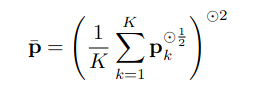


Here calculate the barycenter. Above is the barycenter calculation from the CMMN paper. Equation 6, page 14.


I will calculate by norming over each subject's sum, as recommended by Dr. B on slack.

In [7]:
def compute_normed_barycenter(data, psds=None):
  """

  """

  normalized_psds = []
  if psds is None:
    psds = []
  for i, subj in enumerate(data):
      if psds is None:
          f, Pxx = psd(subj)
          psds.append(Pxx)
          normalized_psds.append(Pxx / np.sum(Pxx))
      else:
          normalized_psds.append(psds[i] / np.sum(psds[i]))

  # now average all together
  per_subj_avgs = []
  for subj in normalized_psds:
      avg = np.mean(subj, axis=0)
      per_subj_avgs.append(np.mean(subj, axis=0)) # necessary due to inhomogenous dimensions

  barycenter = np.mean(per_subj_avgs, axis=0)

  return barycenter


def plot_barycenter(barycenter):
  """
  Plot the normed barycenter of the given data.

  Parameters:
  - barycenter: numpy array containing the normed barycenter of the data
  """
  plt.figure(figsize=(12, 8))
  f = np.linspace(0, 128, 129)
  plt.plot(f, 10 * np.log10(barycenter))

  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Power Spectral Density (dB/Hz)')
  plt.title('Normed Barycenter')
  plt.show()

Below are the filter computation portions. Remember to keep everything in the frequency domain, use irfft not ifft, etc.

For the below, we also have a subj-subj filter computation function here.

In [27]:
def compute_filter_original(data, barycenter, psds=None):
  """
  Compute the filter to transform the given data to the barycenter.

  Parameters:
  - data: list of numpy arrays, each containing EEG data for a subject in the target data (cue / frolich here)
  - barycenter: numpy array containing the normed barycenter of the data

  Returns:
  - freq_filter: numpy array containing the filter in the frequency domain
  - time_filter: numpy array containing the filter in the time domain
  """

  if psds is None:
    psds = []
    for subj in data:
        f, Pxx = psd(subj)
        psds.append(Pxx)

  # here we collapse channels down. our paradigm does not include channel - channel correspondence between domains
  avg_psds_per_subj = [
    np.mean(subj, axis=0) for subj in psds
  ]

  # computing filters now. irfft
  freq_filter_per_subj = []
  for avg_psd_per_subj in avg_psds_per_subj:
    freq_filter = np.sqrt(barycenter) / np.sqrt(avg_psd_per_subj)
    freq_filter_per_subj.append(freq_filter)

  time_filter_per_subj = []
  for subj in freq_filter_per_subj:
    time_filter = np.fft.irfft(subj) # note, now with real values only.
    time_filter_per_subj.append(time_filter)

  return freq_filter_per_subj, time_filter_per_subj


def subj_subj_matching(source_psds, target_psds) -> List[int]:
  """
  Subsidiary function for subj-subj filter computation function below.

  Parameters
  ----------
  source_psds: list of numpy arrays, each containing the PSD of the data for a subject in the source domain. shape (n_channels, n_freqs)
  target_psds: list of numpy arrays, each containing the PSD of the data for a subject in the target domain. shape (n_channels, n_freqs)

  Returns
  -------
  A list of indices, where the i-th element is the index of the source subject that best matches the i-th target subject.
  Ex: target subj 1 and 2 match to source domain 1, target subj 3 matches to source domain 2: [1, 1, 2]
  """

  # average both right away. we don't assume that domains must match # of channels, so do dist matching based on
  correct_source_psds = [np.mean(subj, axis=0) for subj in source_psds]
  correct_target_psds = [np.mean(subj, axis=0) for subj in target_psds]

  # pre-normalized length output. for debug
  # for i, target_psd in enumerate(correct_target_psds):
  #   print(f"For frolich subject {i}, the PSD has length { (1/np.sqrt(2)) * np.sqrt(np.sum(target_psd**2))}")

  # for i, source_psd in enumerate(correct_source_psds):
  #   print(f"For emotion subject {i}, the PSD has length { (1/np.sqrt(2)) * np.sqrt(np.sum(source_psd**2))}")


  # Normalizing so that Hellinger dist makes sense
  # make them sum to one
  for i, target_psd in enumerate(correct_target_psds):
    correct_target_psds[i] = target_psd / np.sum(target_psd)
  for i, source_psd in enumerate(correct_source_psds):
    correct_source_psds[i] = source_psd / np.sum(source_psd)

  # now check again

  # print dist to check normalization. for debug
  # for i, target_psd in enumerate(correct_target_psds):
  #   print(f"For frolich subject {i}, the PSD has length {np.sqrt(np.sum(target_psd**2))}")

  # for i, source_psd in enumerate(correct_source_psds):
  #   print(f"For emotion subject {i}, the PSD has length {np.sqrt(np.sum(source_psd**2))}")

  subj_subj_matches = []
  for i, target_psd in enumerate(correct_target_psds): # frolich
    min_dist = float('inf')
    min_idx = -1
    for j, source_psd in enumerate(correct_source_psds): # emotion
      # dist = np.sqrt(np.sum((np.sqrt(source_psd) - np.sqrt(target_psd))**2)) # just L2
      dist = (1 / np.sqrt(2)) * np.sqrt(np.sum((np.sqrt(source_psd) - np.sqrt(target_psd))**2)) # Hellinger

      # print("distance: ", dist)

      if dist < min_dist:
        # print("distance was lower than min_dist of: ", min_dist)
        min_dist = dist
        min_idx = j
    subj_subj_matches.append(min_idx)

    print(f"Frolich subject {i} has been matched to Emotion subject {min_idx}")

  return subj_subj_matches


def compute_filter_subj_subj(target_psds, source_psds, subj_subj_matches):
  """
  Compute the filter to transform the given data to the barycenter, with subject to subject matching.

  Parameters:
  - target_psds: list of numpy arrays, each containing the PSD of the data for a subject in the target domain. shape (n_channels, n_freqs)
  - source_psds: list of numpy arrays, each containing the PSD of the data for a subject in the source domain. shape (n_channels, n_freqs)
  - subj_subj_matches: list of indices, where the i-th element is the index of the source subject that best matches the i-th target subject.

  Returns:
  - freq_filter: numpy array containing the filter in the frequency domain for each target subject
  - time_filter: numpy array containing the filter in the time domain for each target subject
  """


  freq_filter_per_subj = []
  time_filter_per_subj = []


  averaged_source_psds = []
  averaged_target_psds = []

  # do not assume that there is a channel - channel correspondence, etc. collapse to average PSD
  for psd in source_psds:
    averaged_source_psds.append(np.mean(psd, axis=0))
  for psd in target_psds:
    averaged_target_psds.append(np.mean(psd, axis=0))


  for i, subj in enumerate(averaged_target_psds):
    source_psd = averaged_source_psds[subj_subj_matches[i]]

    freq_filter = np.sqrt(source_psd) / np.sqrt(subj) # sqrt of emotion psd / sqrt of frolich psd
    time_filter = np.fft.irfft(freq_filter) # note: changed from ifft to irfft

    freq_filter_per_subj.append(freq_filter)
    time_filter_per_subj.append(time_filter)

  return freq_filter_per_subj, time_filter_per_subj




# also some plotting funcs
def plot_freq_filter(freq_filter, fs=256):
  """
  Plot the filter in the frequency domain.

  Parameters:
  - freq_filter: numpy array containing the filter in the frequency domain
  - fs: sampling frequency (default: 256 Hz)

  """

  # for subj subj matching, the freq and time filters have channel components still.
  # average before plotting if so

  if freq_filter[0].ndim > 1:
    freq_filter = [np.mean(subj, axis=0) for subj in freq_filter]

  plt.figure(figsize=(12, 8))
  f = np.linspace(0, fs/2, freq_filter[0].shape[-1])
  for i, subj in enumerate(freq_filter):
      plt.plot(f, 10 * np.log10(np.abs(subj.T)), label=f'Subject {i+1}')

  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Filter (dB)')
  plt.title('Frequency Filters')
  plt.legend()
  plt.show()

def plot_time_filter(time_filter, fs=256):
  """
  Plot the filter in the time domain.

  Parameters:
  - time_filter: numpy array containing the filter in the time domain
  - fs: sampling frequency (default: 256 Hz)
  """

  # for subj subj matching, the freq and time filters have channel components still.
  # average before plotting if so

  if time_filter[0].ndim > 1:
    time_filter = [np.mean(subj, axis=0) for subj in time_filter]


  plt.figure(figsize=(12, 8))
  t = np.arange(len(time_filter[0])) / fs
  for i, subj in enumerate(time_filter):
      plt.plot(t, np.real(subj), label=f'Subject {i+1}')

  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title('Time Domain Filter')
  plt.legend()
  plt.show()

Below are the functions for transforming the data.

The original paper transforms the target data to the barycenter of all source subjects. Their experiments relied on very small sleep stage EEG datasets, so this was not an issue for them. I have this as transform_original() below.

We also do a subject-subject matching scheme, where we find the closest subject in the source dataset to the current subject in the target dataset, and then map to that subject specifically. This should retain more information. This is transform_subj_subj() below.

In [21]:
def transform_original(data, time_filter):
  """
  Transform the given data using the given filter.

  Parameters:
  - data: list of numpy arrays, each containing EEG data for a subject in the target data
  - time_filter: list containing the filter in the time domain for each subject

  Returns:
  - transformed_data: list of numpy arrays, each containing the transformed EEG data for a subject
  """

  # Do the transformation on a channel basis

  transformed_data = []
  for i, subj in enumerate(data):
    num_channels = subj.shape[0]
    subj_norm = np.zeros_like(subj)

    for chan in range(num_channels):

      #subj_norm[chan] = np.convolve(subj[chan], time_filter[i], mode='same') # note dr. b wants changed to full b/c of weird reverse shifting
      subj_norm[chan] = np.convolve(subj[chan], time_filter[i], mode='full')[:len(subj[chan])]

    transformed_data.append(subj_norm)

  return transformed_data


def transform_data_subj_subj(data, time_filter_subj_subj):
  """
  Transform data with knowledge that the time filter is a list, with each specific to the individual target domain subject

  Parameters
  ----------
  data
  time_filter_subj_subj

  Returns
  -------

  """

  transformed_data = []
  for i, subj in enumerate(data):
    subj_norm = np.zeros(subj.shape)
    num_channels = subj.shape[0]
    time_filter = time_filter_subj_subj[i] # subj specific time filter

    for chan in range(num_channels):
      # print(subj[chan].shape)
      # print(time_filter[i].shape)
      # subj_norm[chan] = np.convolve(subj[chan], time_filter[chan], mode='same') # here also change this to full, matching the above
      subj_norm[chan] = np.convolve(subj[chan], time_filter[chan], mode='full')[:len(subj[chan])]

    transformed_data.append(subj_norm)

  return transformed_data


# **Computation & Plotting**

Below are plots of base data first, then the computation process.

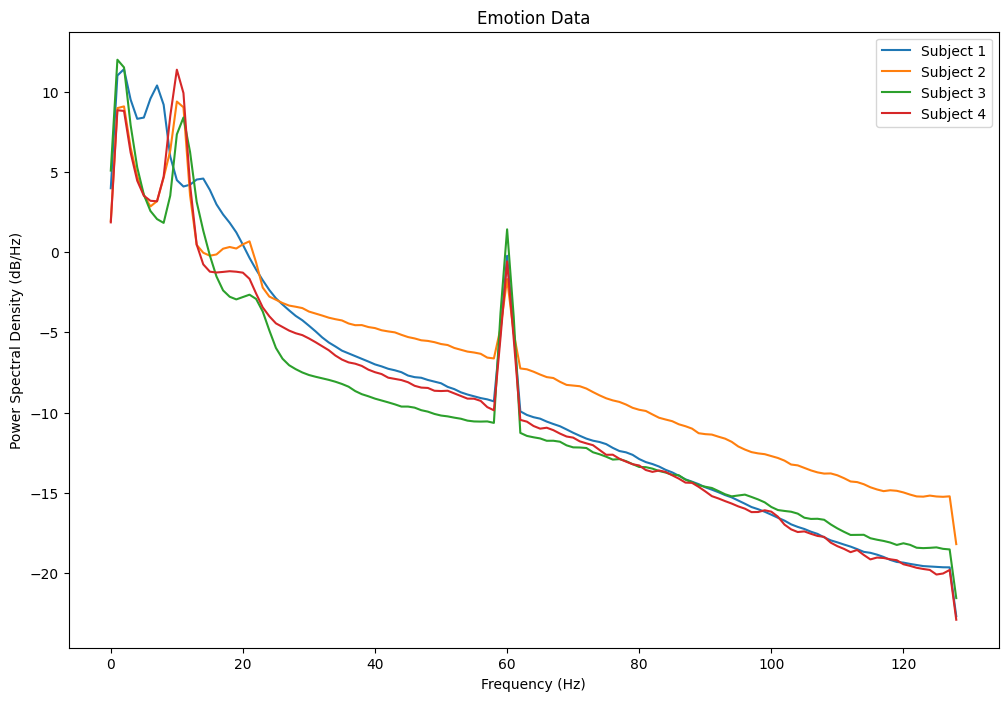

In [10]:
plot_psd(emotion_data, psds=emotion_data_psds_raw, title='Emotion Data')

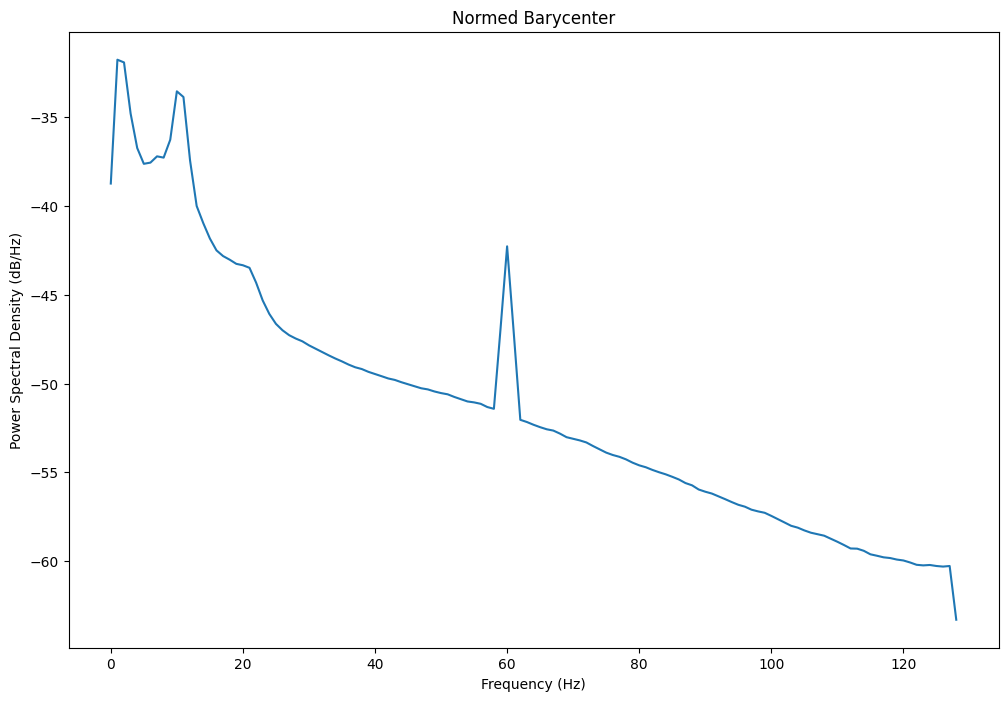

In [11]:
normed_emotion_barycenter = compute_normed_barycenter(emotion_data, psds=emotion_data_psds_raw)
plot_barycenter(normed_emotion_barycenter)

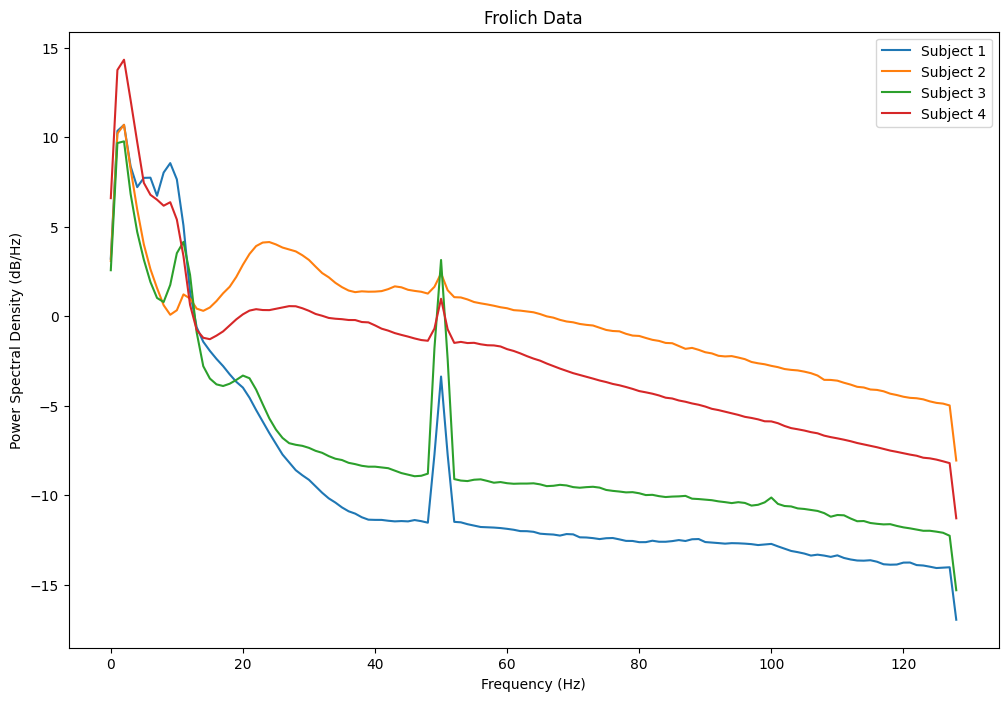

In [96]:
plot_psd(frolich_data, psds=frolich_data_psds_raw, title='Frolich Data')

In [ ]:
# Plotting filters for cue -> emotion
freq_filter, time_filter = compute_filter_original(frolich_data, normed_emotion_barycenter)

In [ ]:
plot_freq_filter(freq_filter)
plot_time_filter(time_filter) # note: still looks wonky but the transformed data seems to be fine

In [ ]:
transformed_data = transform_original(frolich_data, time_filter)

In [ ]:
# plot transformed data
plot_psd(frolich_data, title='Frolich Data Original')
plot_psd(transformed_data, title='Transformed Frolich Data Original CMMN Method')

In [ ]:
# plot raw frolich and transformed frolich
plot_raw_signals(frolich_data, title='Frolich Data')
plot_raw_signals(transformed_data, title='Transformed Frolich Data')

In [ ]:
# Example usage for a single subject:
channel_list = [1, 16, 64]  # specify which channels you want to see
plot_polysomnograph(frolich_data[0], channel_indices=channel_list, time_window=(0, 5), title='First Frolich Subject, 5 seconds, Original')  # show first 60 seconds, for first subject of frolich

plot_polysomnograph(transformed_data[0], channel_indices=channel_list, time_window=(0, 5), title='First Frolich Subject, 5 seconds, Transformed')  # show first 60 seconds, for first subject of frolich

In [ ]:
# plot with all channels

# there are very many channels, so just do with 1 subject to start

plot_raw_signals(frolich_data[0], title='Frolich Data', all_channels=True)
plot_raw_signals(transformed_data[0], title='Transformed Frolich Data', all_channels=True)

In [28]:
subj_subj_matches = subj_subj_matching(emotion_data_psds_raw, frolich_data_psds_raw)

freq_filter_subj_subj, time_filter_subj_subj = compute_filter_subj_subj(frolich_data_psds_raw, emotion_data_psds_raw, subj_subj_matches)

transformed_data_subj_subj = transform_data_subj_subj(frolich_data, time_filter_subj_subj)

Frolich subject 0 has been matched to Emotion subject 0
Frolich subject 1 has been matched to Emotion subject 1
Frolich subject 2 has been matched to Emotion subject 2
Frolich subject 3 has been matched to Emotion subject 1


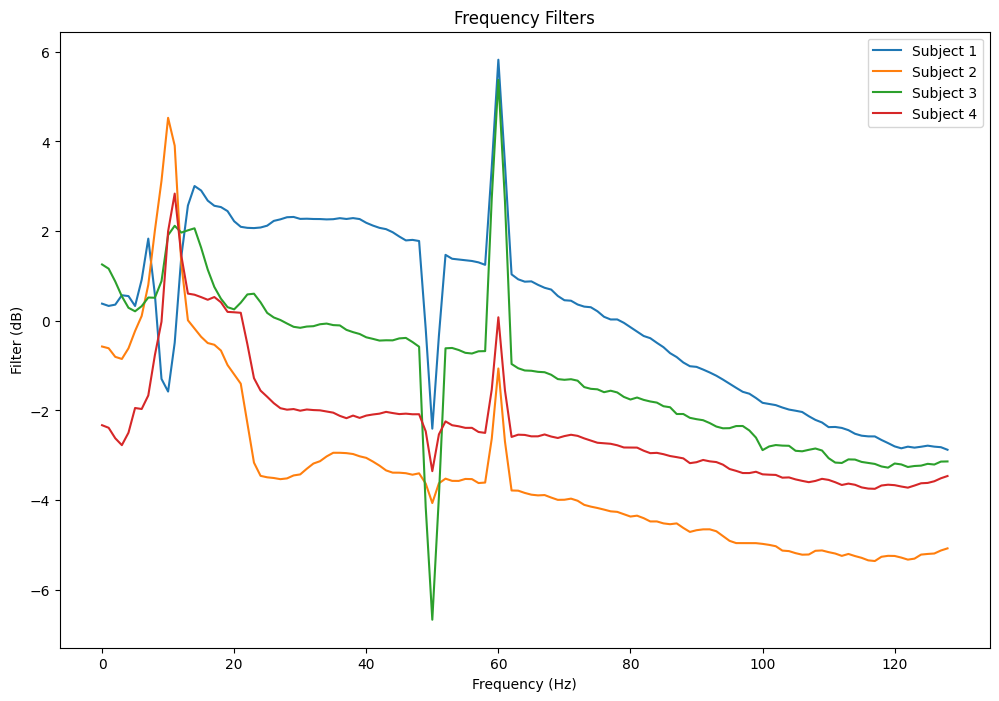

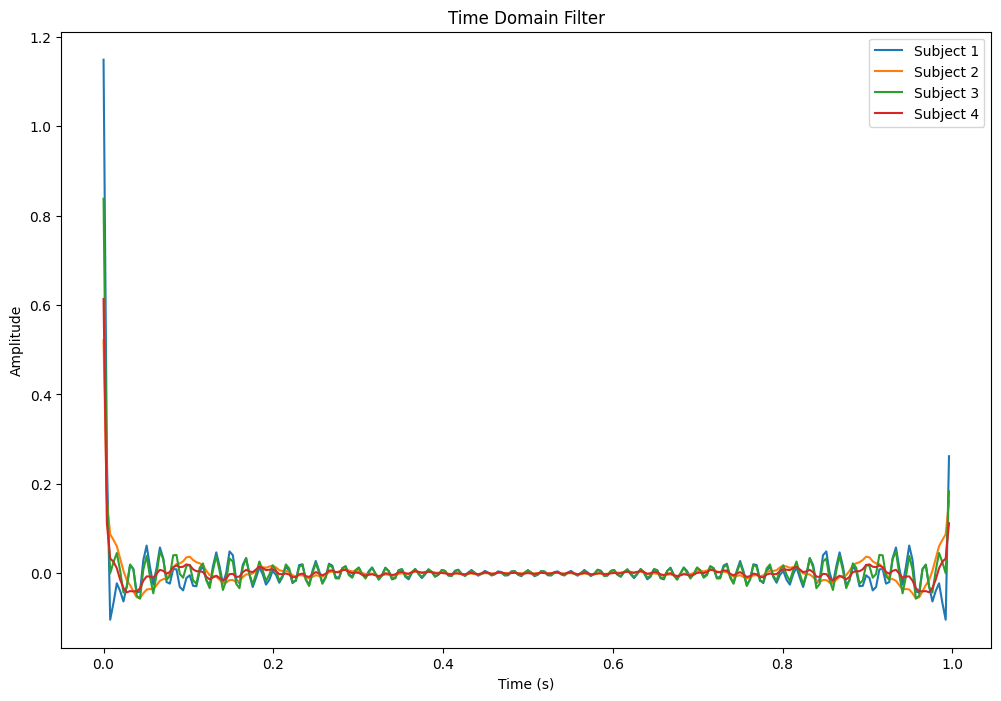

In [29]:
plot_freq_filter(freq_filter_subj_subj)
plot_time_filter(time_filter_subj_subj)

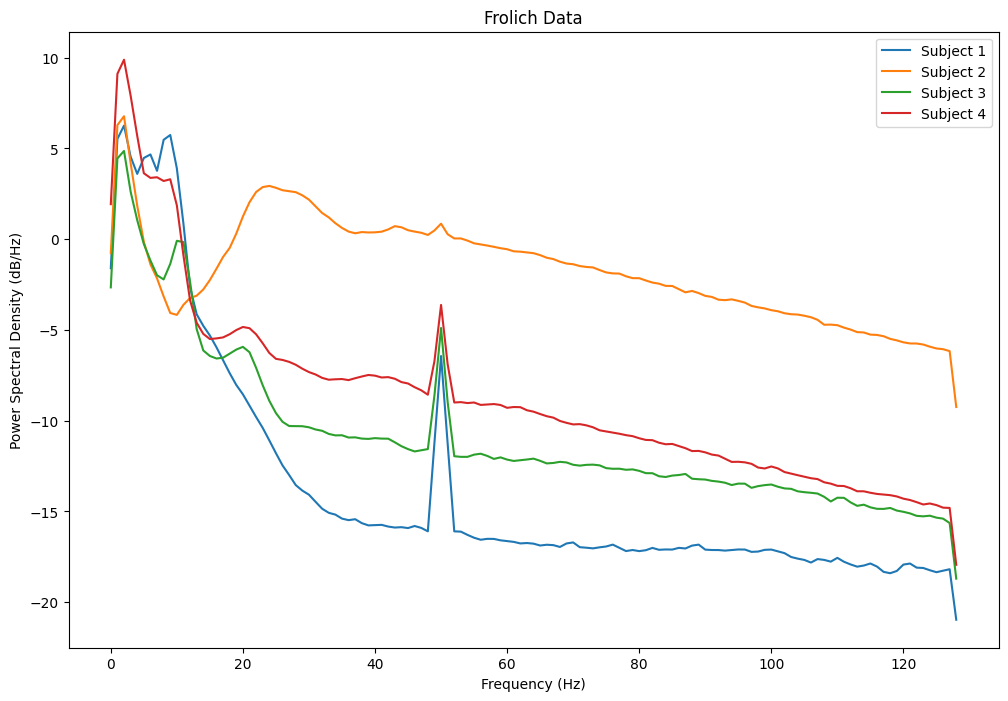

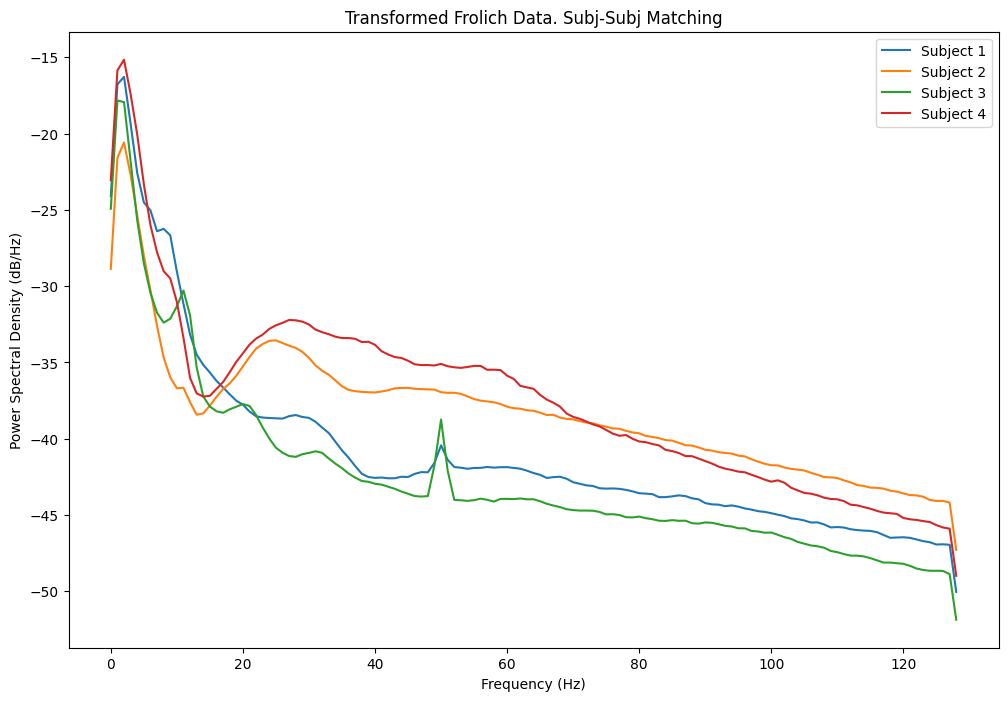

In [30]:
# plot original frolich data as well
plot_psd(frolich_data, title='Frolich Data')
plot_psd(transformed_data_subj_subj, title='Transformed Frolich Data. Subj-Subj Matching')

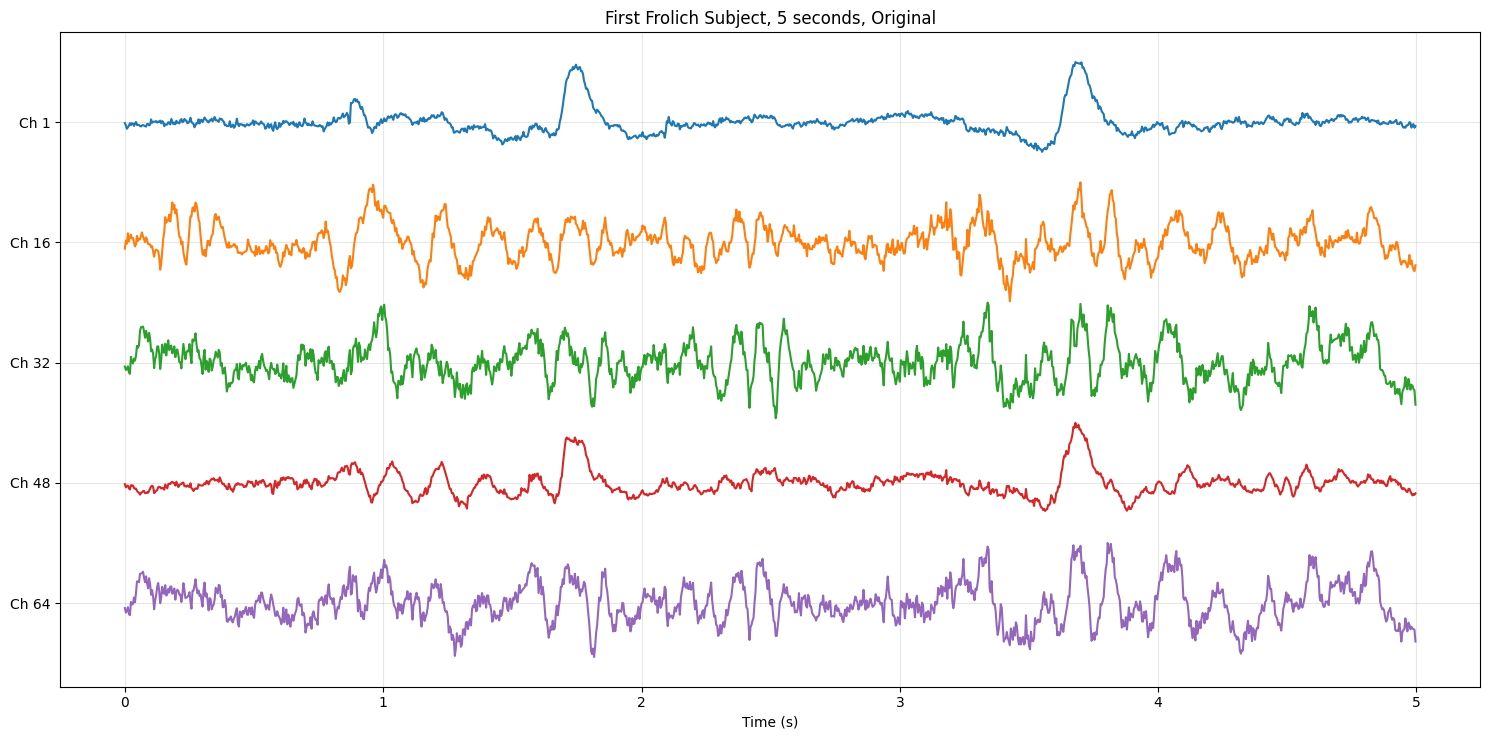

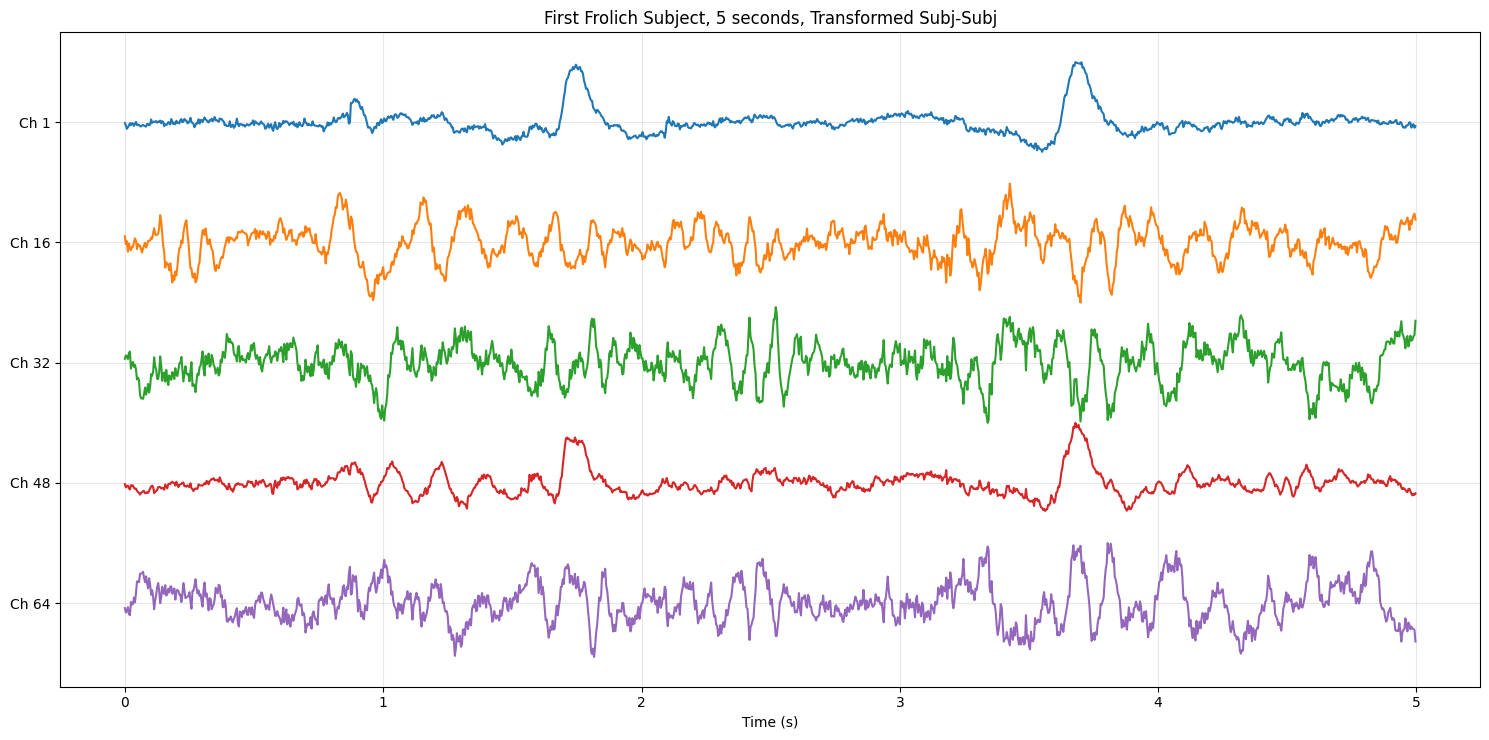

In [33]:
# Example usage for a single subject:
channel_list = [1, 16, 32, 48, 64]  # specify which channels you want to see
plot_polysomnograph(frolich_data[0], channel_indices=channel_list, time_window=(0, 5), title='First Frolich Subject, 5 seconds, Original')  # show first 60 seconds, for first subject of frolich

plot_polysomnograph(transformed_data_subj_subj[0], channel_indices=channel_list, time_window=(0, 5), title='First Frolich Subject, 5 seconds, Transformed Subj-Subj')  # show first 60 seconds, for first subject of frolich